In [97]:
from process_edus import EDUSample

In [17]:
data = EDUSample()
path = r'../LabeledEDUS_final.txt'

edus, targets = data.read_labeled(path)

=====> DATA LOADED


In [18]:
import tensorflow as tf

In [19]:
import numpy as np

from sklearn.metrics import precision_recall_fscore_support, accuracy_score

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.initializers import Constant
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.layers import Input, Dense, Flatten, Embedding, Dropout, Conv1D, MaxPooling1D, GlobalMaxPooling1D

In [20]:
GLOVE_PATH = r'../../../GloVe/glove.6B.100d.txt'

In [21]:
# tokenize edus
t = Tokenizer()
t.fit_on_texts(edus)
vocab_size = len(t.word_index) + 1

# integer encode the documents
encoded_edus = t.texts_to_sequences(edus)

# max_length = 1 << (max(map(lambda x: len(x), encoded_edus)) - 1).bit_length()  # pad to smallest power of 2 greater than the largest edu
max_length = sum(map(lambda x: len(x), encoded_edus)) // len(encoded_edus)       # pad to the average length of edus
padded_edus = pad_sequences(encoded_edus, maxlen=max_length)

In [22]:
X_train, y_train, X_test, y_test = data.split_data(padded_edus, targets)

In [23]:
print('Preparing embedding matrix.')
# load the whole embedding into memory
embeddings_index = dict()
f = open(GLOVE_PATH)
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Preparing embedding matrix.
Loaded 400000 word vectors.


In [93]:
# Using regularization 
regularizer = None
regularization = True
dropout = True
if regularization:
    regularizer = l1(0.00001)

In [94]:
print('Model Setup') 

inputs = Input(shape=(max_length,), dtype='int32')
embed_sequence = Embedding(vocab_size, 100, 
                           #weights=[embedding_matrix],
                           embeddings_initializer=Constant(embedding_matrix), 
                           input_length=max_length,
                           trainable=False)(inputs)

x = Dense(256, activation='sigmoid', kernel_regularizer=regularizer)(embed_sequence)

if dropout:
    x = Dropout(0.25)(x)

x = Flatten()(x)

preds = Dense(1, activation='sigmoid', name='output_layer')(x)

model = Model(inputs, preds)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

print('Fitting model')
model.fit(X_train, y_train, 
          epochs=100,
          batch_size=None
         )

Model Setup
Fitting model
Epoch 1/100
2266/2266 [==============================] - 2s 753us/step - loss: 0.7152 - acc: 0.5300
Epoch 2/100
2266/2266 [==============================] - 0s 134us/step - loss: 0.6704 - acc: 0.6161
Epoch 3/100
2266/2266 [==============================] - 0s 141us/step - loss: 0.6219 - acc: 0.6726
Epoch 4/100
2266/2266 [==============================] - 0s 133us/step - loss: 0.5856 - acc: 0.7070
Epoch 5/100
2266/2266 [==============================] - 0s 135us/step - loss: 0.5631 - acc: 0.7202
Epoch 6/100
2266/2266 [==============================] - 0s 140us/step - loss: 0.5476 - acc: 0.7370
Epoch 7/100
2266/2266 [==============================] - 0s 137us/step - loss: 0.5385 - acc: 0.7458
Epoch 8/100
2266/2266 [==============================] - 0s 133us/step - loss: 0.5288 - acc: 0.7639
Epoch 9/100
2266/2266 [==============================] - 0s 138us/step - loss: 0.5165 - acc: 0.7643
Epoch 10/100
2266/2266 [==============================] - 0s 158us/step - 

In [95]:
results = model.predict(X_test)
results = np.array([0 if r < 0.5 else 1 for r in results])

In [96]:
# m = model.evaluate(X_test, y_test)
model.evaluate(X_test, y_test), model.evaluate(X_train, y_train)

2266/2266 [==============================] - 0s 52us/step


([0.6656858978919613, 0.7511032659820193],
 [0.2725239859307012, 0.9223300971399865])

In [84]:
accuracy_score(y_test, results)

0.7475728155339806

In [66]:
precision_recall_fscore_support(y_test, results, average='macro')

/home/heyson/.conda/envs/iitml/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(0.2612533097969991, 0.5, 0.34318840579710147, None)

In [44]:
# list(zip(model.predict(X_train), y_train))

Using TensorFlow backend.


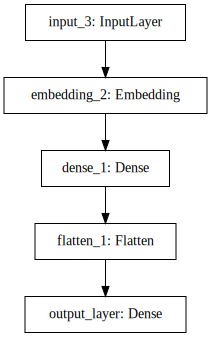

In [35]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))